# **3-1-1 - Street Cleaning Requests in San Francisco**
A deep dive into the defilement of San Francisco

# Table of Contents
1. [Motivation](#Motivation)
2. [Basic Statistics](#Basic-Statistics)
    - [Dataset 1 - 311 Cases in San Francisco](#Dataset-1---311-Cases-in-San-Francisco)
    - [Dataset 2 - Police Department Incident Reports: Historical 2003 to May 2018](#Dataset-2---Police-Department-Incident-Reports:-Historical-2003-to-May-2018)
    - [Dataset 3 - Police Department Incident Reports: 2018 to Present](#Dataset-3---Police-Department-Incident-Reports:-2018-to-Present)
3. [Data analysis](#Data-Analysis)
4. [Genre](#genre)
5. [Visualizations](#visualizations)
    - [Total 311 requests over time (Bar chart)](#Total-311-requests-over-time-(Bar-chart))
    - [Examples of requested cleaning tickets (Slideshow)](#Examples-of-requested-cleaning-tickets-(Slideshow))
    - [Category-wise change in 311 requests over time (Time series)](#Category-wise-change-in-311-requests-over-time-(Time-series))
    - [District-wise yearly 311 requests (Interactive map plot)](#District-wise-yearly-311-requests-(Interactive-map-plot))
    - [District-wise yearly crime reports (Interactive map plot) (Comparison)](#District-wise-yearly-crime-reports-(Interactive-map-plot)-(Comparison))
6. [Discussion](#discussion)
7. [Contributions](#contributions)

This notebook serves as a behind-the-scenes explanation of our project. It is meant to be read as a supplement to our story on 3-1-1 Street Cleaning Requests in San Francisco that is posted [here](https://gustavhansen99.github.io/SocialDataFinalProject/) in the case that you felt more curious about the technical details of our project. However, it is not necessary to read this notebook in order to understand our website.

In order to run the notebook all libraries defined below must be installed and loaded on your machine.

In [12]:
# Data imports
import pandas as pd
import matplotlib.pyplot as plt


# Slideshow imports
import io
import os
import re
import requests
from PIL import Image
import folium


# Plotly imports
import plotly.graph_objs as go
import json

# Bokeh imports
from bokeh.io import curdoc, show
from bokeh.plotting import figure, output_file
from bokeh.models import HoverTool, NumeralTickFormatter
from bokeh.themes import Theme

/Users/Gustav/miniconda3/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning:

urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!



# Motivation

# Basic statistics

## Dataset 1 - 311 Cases in San Francisco

## Dataset 2 - Police Department Incident Reports: Historical 2003 to May 2018

## Dataset 3 - Police Department Incident Reports: 2018 to Present

# Data Analysis

# Genre

# Visualizations

Loading and preprocessing of data might depend on the visualizations. Therefore, we will load and preprocess the data for each visualization separately.

In [7]:
cols_of_interest = ['Opened', 'Closed', 'Updated', 'Status', 'Status Notes', 'Responsible Agency', 'Category', 'Request Type', 'Request Details', 'Address', 'Supervisor District', 'Neighborhood', 'Latitude', 'Longitude', 'Source', 'Media URL']

data = pd.read_csv('/Users/Gustav/Downloads/311_Cases0105.csv', usecols=cols_of_interest)

# convert to datetime
data['Opened'] = pd.to_datetime(data['Opened'])
data['Closed'] = pd.to_datetime(data['Closed'])
# create a column called yearmonth that contain the year and month of the opened date
data['yearmonth'] = data['Opened'].apply(lambda x: str(x.year) + '-' + str(x.month) + '-01')
data['Year'] = data['Opened'].dt.year
# create a column for that contain the time taken for each request to be closed
data['time_taken'] = data['Closed'] - data['Opened']
# convert the time_taken column to hours
data['time_taken'] = data['time_taken'].astype('timedelta64[h]')

# take dataframe and get a count of every Request Details value summed by month and year
df = data[(data['Category']=="Street and Sidewalk Cleaning")]
# remove rows where latitude or longitude is null or zero
df = df[(df['Latitude']!=0) | (df['Longitude']!=0)]

### Fix Request details types that have different names but are the same
## Garbage and Debris
df['Request Details'] = df['Request Details'].replace(['Other Loose Garbage', 'Other Loose Garbage / Debris', 'Auto_accident_debris',
                                                       'Garbage and Debris - N/A','Garbage and Debris - {{nature_of_request.label}}',
                                                        'Garbage and Debris - {{request_type.label}}'],
                                                        "Loose Garbage and Debris")
## Overflowing city garbage can
df['Request Details'] = df['Request Details'].replace(['City_garbage_can_overflowing', 'Overflowing city receptacle or dumpster',
                                                        'Overflowing_City_Receptacle_or_Dumpster'], "Overflowing City Garbage Can")
## Illegal dumping
df['Request Details'] = df['Request Details'].replace(['Illegal Dumping', 'Illegal dumping', 'Illegal_Dumping'], "Illegal Dumping")
## Furniture, mattresses and refrigerators
df['Request Details'] = df['Request Details'].replace(['Furniture', 'Mattress', 'Refrigerator'], "Furniture, Mattresses and Refrigerators")
## Sidewalk or street cleaning
df['Request Details'] = df['Request Details'].replace(['Sidewalk_Cleaning', 'Sidewalk cleaning', 'Street_Cleaning', 'Street cleaning'], "Sidewalk or Street Cleaning")
## Missed Route Mechanical Sweeping
df['Request Details'] = df['Request Details'].replace(['Missed_Route_Mechanical_Sweeping', 'Missed route - mechanical sweeping'], "Missed Route Mechanical Sweeping")


### Rename some values to be more pretty
## Transit_shelter_platform
df['Request Details'] = df['Request Details'].replace(['Transit_shelter_platform'], "Transit Shelter Platform")
## Christmas tree
df['Request Details'] = df['Request Details'].replace(['Christmas_tree'], "Christmas Tree")
## Event_parade_mess
df['Request Details'] = df['Request Details'].replace(['Event_parade_mess'], "Event Parade Mess")
## Missed_TrashRecycleCompost_Collection
df['Request Details'] = df['Request Details'].replace(['Missed_TrashRecycleCompost_Collection'], "Missed Trash Recycle Compost Collection")
## Medical_waste
df['Request Details'] = df['Request Details'].replace(['Medical_waste'], "Medical Waste")
## GarbageTransit
df['Request Details'] = df['Request Details'].replace(['GarbageTransit'], "Garbage Transit")
## OtherTransit
df['Request Details'] = df['Request Details'].replace(['OtherTransit'], "Other Transit")
## PostAbatementInspection
df['Request Details'] = df['Request Details'].replace(['PostAbatementInspection'], "Post Abatement Inspection")

/var/folders/1j/15c8wxfx0rz57_sf9j19y3fh0000gp/T/ipykernel_36536/684083803.py:3: DtypeWarning:

Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.



For most of the visualizations, we want to focus on only a subset of the Request Types. Therefore, we define a preferred columns variable below that we will use throughout the notebook.

In [10]:
pref_cols = ["Loose Garbage and Debris", "Furniture, Mattresses and Refrigerators", "Boxed or Bagged Items", "Human or Animal Waste", "Electronics", 
             "Glass", "Needles", "Liquids - Oil/Paint/Other", "Transit Shelter Platform", "Christmas Tree"]

## Total 311 requests over time (Bar chart)

In [13]:
yearly_counts = df.groupby('Year').size()
yearly_counts = yearly_counts.drop(2023)

hover_text = [f"<b>{val/1000:.1f}k</b> <extra></extra>" if val >= 1000 else str(val) for val in yearly_counts.values]

fig = go.Figure(go.Bar(
    x=yearly_counts.index,
    y=yearly_counts.values,
    hovertemplate=hover_text,
    marker_color='#487C4F',
    marker_line_color='black',
    marker_line_width=1,
    hoverlabel=dict(bgcolor="gold"),
))

# Set x-axis ticks to show all years
fig.update_layout(xaxis=dict(dtick=1))

fig.update_layout(height = 550,
                    width = 950,
                    autosize=True,
                    paper_bgcolor= "#E8ECEB",
                    margin={"r":10,"t":0,"l":10,"b":0},
                    font_family = "Garamond",
                    font_size = 18,
                    xaxis_title="Year",
                    yaxis_title="Number of Requests",
                    )
fig.update_layout(
    plot_bgcolor='#E8ECEB'
)

fig.show()

## Examples of requested cleaning tickets (Slideshow)

To create the slideshow that showcases some of the situations where a ticket has been requested with an attached media URL, we utilize this to download the images and display them in the slideshow. However, the idea for a slideshow did not come until after we started looking into the data, and more specifically the time taken for requests to go from opened to closed. Effectively showing the effectiveness of the city of San Francisco in handling the requests and prioritising the massive amount of requests they receive. Therefore, for this visualization, we start by presenting some of the background for the slideshow through a time taken distribution and boxplot.

In [8]:
# compute the average, min and max of the time_taken column for each Request Details value
df_time_taken = df.groupby('Request Details')['time_taken'].agg(['median', 'min', 'max'])
df_time_taken

,median,min,max
Request Details,,,
Boxed or Bagged Items,4.0,-586.0,40222.0
Car Batteries,39.5,-11.0,17564.0
Christmas Tree,32.0,0.0,9294.0
Electronics,5.0,-300.0,81217.0
Event Parade Mess,26.0,-11.0,38569.0
"Furniture, Mattresses and Refrigerators",5.0,-301.0,83874.0
Garbage Transit,3.5,0.0,146.0
Glass,20.0,-8013.0,68645.0
Hazardous Waste Containers,22.0,-7.0,36497.0


From the above table, we are able to see that the time taken of every request category contain a significant amount of outliers. Firstly, this insight sparked an interest in exploring why we see all these outliers - are they extreme cleaning requests or is the city handling them poorly? Secondly, because of the outliers, we knew that visualizing the distributions in a boxplot would be difficult and noisy to get useful information from. However, we gave it a go.

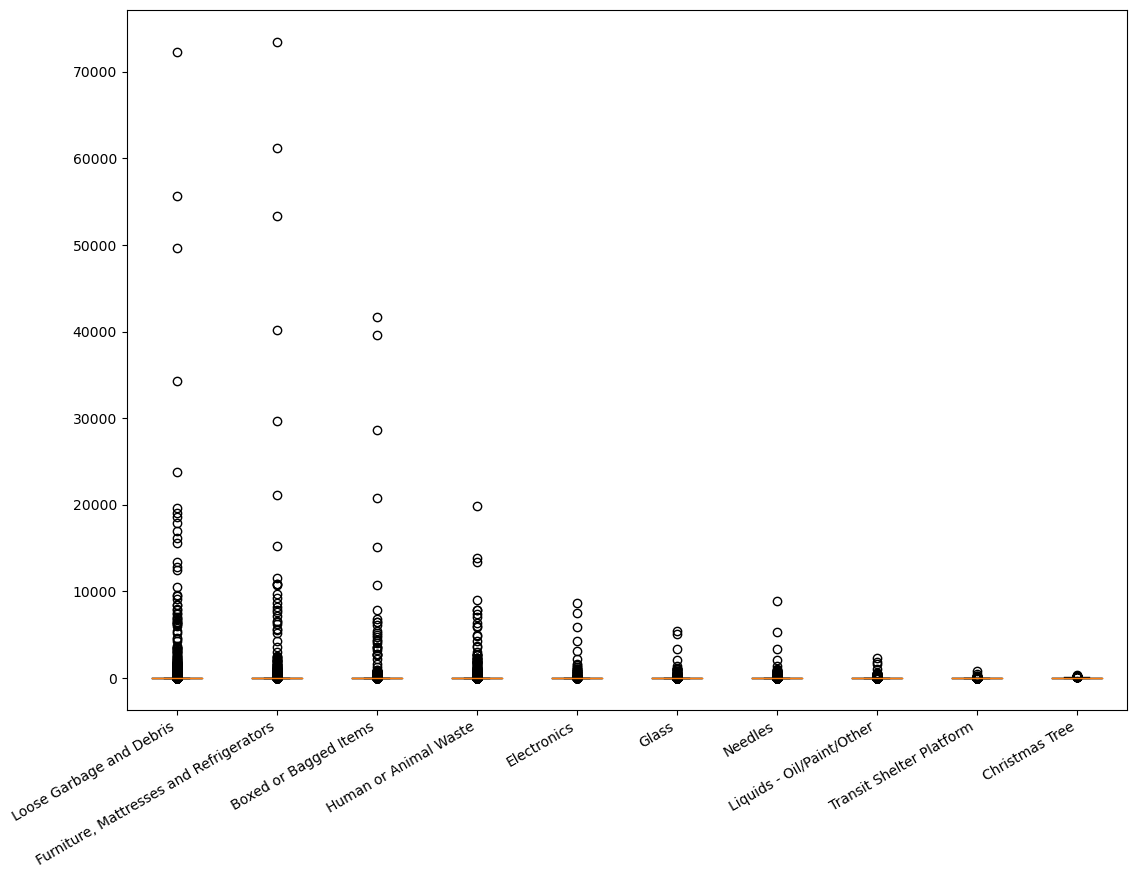

In [11]:
boxplot_df = df.copy()
boxplot_plotting_data = []
for request_type in pref_cols:
    boxplot_plotting_data.append(boxplot_df[boxplot_df["Request Details"] == request_type]['time_taken'].value_counts())

fig = plt.figure(figsize=(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(boxplot_plotting_data)
 
ax.set_xticklabels(pref_cols, rotation=30, ha='right')
# show plot
plt.show()

So, at this point we conclude that the amount of outliers simply makes the boxplot too noisy to be useful. Therefore, we move on to show the requests in another (more simple) way. We randomly select 5 requests that contain a media URL and display them in a slideshow. Since we aim at a slideshow that contain images of the same sizes, we however filter the images to get a specific size. In this way, we hope to give the reader a sense of the different types of requests that are being made, and how significant some of the issues are. We also hope that this type of visualizing the data will be more engaging for the reader.

In [ ]:
time_taken_images = df[(df['Media URL'].notnull()) & (df['Neighborhood'].notnull()) & (df['time_taken'].notnull())]

for idx, row in time_taken_images.iterrows():
    image_url = row['Media URL']
    hours = row['time_taken']
    # request details without spaces and special characters
    request_details = row['Request Details'].replace(" ", "_").replace("/", "_").replace("'", "")
    # neighborhood without spaces and special characters
    neighborhood = row['Neighborhood'].replace(" ", "_").replace("/", "_").replace("'", "")
    # longitute and latitude
    lat = row['Latitude']
    lon = row['Longitude']
    category = row['Request Details']
    try:
        img_data = requests.get(image_url, timeout=10).content
        
        img = Image.open(io.BytesIO(img_data))
        # if image is not 1164x768 or 1536x834, skip
        if img.size == (1164, 768):
            image_name = f'/Users/Gustav/Downloads/SocialDataOutliers/1164x768/{request_details}_{hours}_{neighborhood}_lat{lat}_lng{lon}.jpg'
            # if image_name already exists, skip
            if os.path.isfile(image_name):
                continue
            with open(image_name, 'wb') as handler:
                handler.write(img_data)
        elif img.size == (1536, 834):
            image_name = f'/Users/Gustav/Downloads/SocialDataOutliers/1536x834/{request_details}_{hours}_{neighborhood}_lat{lat}_lng{lon}.jpg'
            # if image_name already exists, skip
            if os.path.isfile(image_name):
                continue
            with open(image_name, 'wb') as handler:
                handler.write(img_data)
        else:
            continue
        
    except requests.exceptions.Timeout as err:
        print(f'Could not download image for {request_details} with url {image_url}')
        continue
    
    

To provide the images with some more context, we create a map of San Francisco with a marker for the location of the request. This is done by using the folium library. We then overlay the map on the original request media URL and show both in one. Hence, the reader will be able to easily see the exact location of the request, and connect that information with the overall story of our website.

In [ ]:
path = "/Users/Gustav/Downloads/slideshow"
for image in os.listdir(path):
    filename = os.path.join(path, image)
    # check that the file is a jpg
    if not filename.endswith(".png"):
        continue
    # get numbers from filename after "lat" and "lng"
    lat = float(re.findall(r'_lat(.*?)_lng', filename)[0])
    lng = float(re.findall(r'_lng(.*?).png', filename)[0])

    SF_map = folium.Map([37.7749, -122.4194], tiles = "Stamen Toner", zoom_start=12.4)
    folium.Marker([lat, lng]).add_to(SF_map)
    SF_map.save(f"{filename}_map.html")

In [ ]:
for image in os.listdir(path):
    filename = os.path.join(path, image)
    # check that the file is a jpg
    if not filename.endswith(".png"):
        continue
    # check whether the file contain "map" in it
    if "map" in filename:
        continue
    case_img = Image.open(filename)
    map_img = Image.open(f"{filename}_map.png")
    map_img = map_img.resize((250, 250))
    case_img.paste(map_img, (0,0), mask=map_img)
    case_img.save(f"{filename}_combine.jpg")

## Category-wise change in 311 requests over time (Time series)

## District-wise yearly 311 requests (Interactive map plot)

In [ ]:
# define traces and buttons at once
data_slider = []
years = [yeari for yeari in range(2008, 2024)]
for year in years:
    df_segmented = geo_data[(geo_data['Year']== year)]
    map = go.Choroplethmapbox(geojson=json.loads(df_segmented.to_json()),
                                    z = list(df_segmented["Total"]),
                                    locations = df_segmented.index,
                                    colorscale=GEOMAP_CMAP,
                                    colorbar=dict(
                                        title=f'Number of cases',
                                        titleside='top',
                                        len=0.8,
                                        orientation = "h",
                                        y = -0.23),
                                    visible=False,
                                    hovertemplate= f"""Number of cases: """ +  """%{z}<br>Neighborhood: %{text}<extra></extra>""",
                                    text = df_segmented.index)
    data_slider.append(map)

# start with year 2023
data_slider[15].visible = True

steps = []
for i in range(len(data_slider)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(data_slider)}],
        label='{}'.format(i + 2008)  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=15,
    pad={"t": 1},
    steps=steps,
    len=0.8,
    x=0.1,
    y=1.28,
    yanchor='top',
    currentvalue=dict(
        font=dict(size=22, family="Garamond"),
        prefix="",
        xanchor="center",
        visible=True
    )
)]

# Show figure
fig = go.Figure(data=data_slider,
                layout=dict(sliders=sliders))

fig.update_layout(mapbox_style="carto-positron",
                    height = 700,
                    width = 1000,
                    autosize=True,
                    paper_bgcolor= "#E8ECEB",
                    margin={"r":10,"t":0,"l":10,"b":0},
                    mapbox=dict(center={"lat": 37.771, "lon": -122.4256},zoom=10.9),
                    font_family = "Garamond",
                    font_size = 18
                    )
fig['layout']['sliders'][0]['pad']=dict(l= 0, t= 18, b=0,)

fig.show()
#fig.write_html("SF_mapYearlyV2.html")

## District-wise yearly crime reports (Interactive map plot) (Comparison)

In [ ]:
# define traces and buttons at once
data_slider = []
years = [yeari for yeari in range(2008, 2024)]
for year in years:
    df_segmented = crime_geo_data[(crime_geo_data['Year']== year)]
    map = go.Choroplethmapbox(geojson=json.loads(df_segmented.to_json()),
                                    z = list(df_segmented["TotalReports"]),
                                    locations = df_segmented.index,
                                    colorscale=GEOMAP_CMAP,
                                    colorbar=dict(
                                        title=f'Number of crimes',
                                        titleside='top',
                                        len=0.8,
                                        orientation = "h",
                                        y = -0.23),
                                    visible=False,
                                    hovertemplate= f"""Number of cases: """ +  """%{z}<br>Neighborhood: %{text}<extra></extra>""",
                                    text = df_segmented.index)
    data_slider.append(map)

# start with year 2023
data_slider[15].visible = True

steps = []
for i in range(len(data_slider)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(data_slider)}],
        label='{}'.format(i + 2008)  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=15,
    pad={"t": 1},
    steps=steps,
    len=0.8,
    x=0.1,
    y=1.28,
    yanchor='top',
    currentvalue=dict(
        font=dict(size=22, family="Garamond"),
        prefix="",
        xanchor="center",
        visible=True
    )
)]

# Show figure
fig = go.Figure(data=data_slider,
                layout=dict(sliders=sliders))

fig.update_layout(mapbox_style="carto-positron",
                    height = 700,
                    width = 1000,
                    autosize=True,
                    paper_bgcolor= "#E8ECEB",
                    margin={"r":10,"t":0,"l":10,"b":0},
                    mapbox=dict(center={"lat": 37.771, "lon": -122.4256},zoom=10.9),
                    font_family = "Garamond",
                    font_size = 18
                    )
fig['layout']['sliders'][0]['pad']=dict(l= 0, t= 18, b=0,)

fig.show()
#fig.write_html("SF_CrimemapYearlyV2.html")

# Discussion

# Contributions